# Detecção de Anomalias Usando Distribuição Gaussiana


> ☝Antes de prosseguir com esta demonstração, você pode querer dar uma olhada em:
> - 📗[Matemática por trás da Detecção de Anomalias](https://github.com/trekhleb/homemade-machine-learning/tree/master/homemade/anomaly_detection)

**Detecção de anomalias** (também **detecção de outliers**) é a identificação de itens, eventos ou observações raras que levantam suspeitas por diferirem significativamente da maioria dos dados.

A distribuição **normal** (ou **gaussiana**) é uma distribuição de probabilidade contínua muito comum. Distribuições normais são importantes em estatística e são frequentemente usadas nas ciências naturais e sociais para representar variáveis aleatórias reais cujas distribuições não são conhecidas. Uma variável aleatória com distribuição gaussiana é dita normalmente distribuída e é chamada de desvio normal.

> **Projeto de Demonstração:** Nesta demonstração, construiremos um modelo que encontrará anomalias nos parâmetros operacionais do servidor, como `Latência` e `Taxa de Transferência`.

In [1]:
# Para facilitar a depuração do módulo logistic_regression, habilitamos o recurso de recarregamento automático dos módulos importados.
# Ao fazer isso, você pode alterar o código da biblioteca logistic_regression e todas essas mudanças estarão disponíveis aqui.
%load_ext autoreload
%autoreload 2

# Adicionar a pasta raiz do projeto aos caminhos de carregamento de módulos.
import sys
sys.path.append('../..')

### Importar Dependências

- [pandas](https://pandas.pydata.org/) - biblioteca que usaremos para carregar e exibir os dados em uma tabela
- [numpy](http://www.numpy.org/) - biblioteca que usaremos para operações de álgebra linear
- [matplotlib](https://matplotlib.org/) - biblioteca que usaremos para plotar os dados

In [2]:
# Importar dependências de terceiros.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importar implementação personalizada de detecção de anomalias Gaussiana.
from homemade.anomaly_detection import GaussianAnomalyDetection


### Carregar os Dados

Nesta demonstração, usaremos o conjunto de dados com parâmetros operacionais do servidor, como `Latência` e `Taxa de Transferência`, e tentaremos encontrar anomalias neles.


In [3]:
# Carregar os dados.
pd_data = pd.read_csv('../../data/server-operational-params.csv')

# Imprimir a tabela de dados.
pd_data.head(10)


,Latency (ms),Throughput (mb/s),Anomaly
0,13.046815,14.741152,0
1,13.408520,13.763270,0
2,14.195915,15.853181,0
3,14.914701,16.174260,0
4,13.576700,14.042849,0
5,13.922403,13.406469,0
6,12.822132,14.223188,0
7,15.676366,15.891691,0
8,16.162875,16.202998,0
9,12.666451,14.899084,1


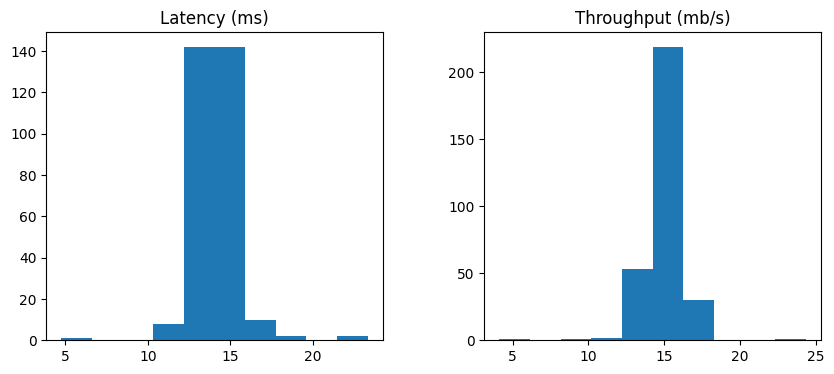

In [4]:
# Imprimir histogramas para cada característica para ver como elas variam.
histohrams = pd_data[['Latency (ms)', 'Throughput (mb/s)']].hist(grid=False, figsize=(10,4))


### Plotar os Dados

Vamos plotar a dependência `Throughput (Latência)` e ver se a distribuição é semelhante à Gaussiana.


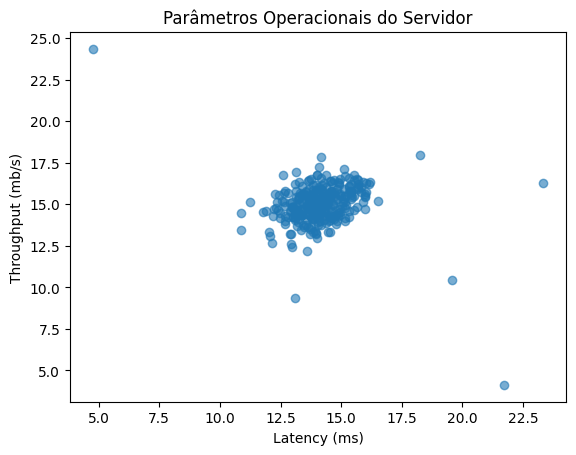

In [5]:
# Extrair as duas primeiras colunas do conjunto de dados.
data = pd_data[['Latency (ms)', 'Throughput (mb/s)']].values

# Plotar os dados.
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Parâmetros Operacionais do Servidor')
plt.show()


### Encontrar Anomalias Usando Distribuição Gaussiana

Vamos tentar usar nossa implementação personalizada de detecção de anomalias usando distribuição Gaussiana.


In [6]:
# Inicializar a instância de detecção de anomalias Gaussiana.
gaussian_anomaly = GaussianAnomalyDetection(data)

# Vamos ver os parâmetros estimados pela distribuição Gaussiana.
print('mu')
print(gaussian_anomaly.mu_param)

print('\n')

print('sigma^2')
print(gaussian_anomaly.sigma_squared)


mu
[14.11222578 14.99771051]


sigma^2
[1.83263141 1.70974533]


### Visualizar o Ajuste

Vamos desenhar gráficos de contorno que representarão nossa distribuição Gaussiana para o conjunto de dados.


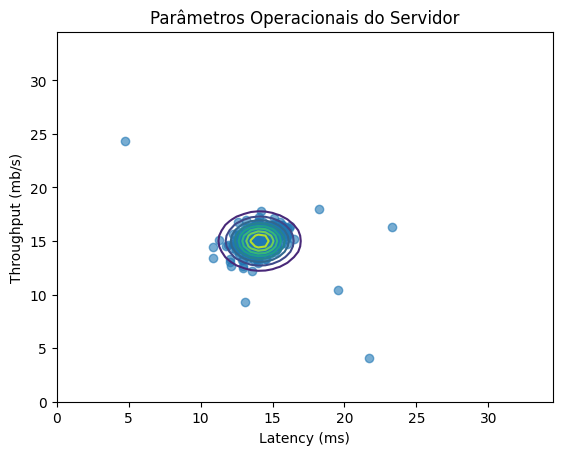

In [7]:
# Criar uma grade 3D para construir gráficos de contorno.

# Criar faixas ao longo dos eixos X e Y.
latency_from = 0
latency_to = 35

throughput_from = 0
throughput_to = 35

step = 0.5

latency_range = np.arange(latency_from, latency_to, step)
throughput_range = np.arange(throughput_from, throughput_to, step)

# Criar grades X e Y.
(latency_grid, throughput_grid) = np.meshgrid(latency_range, throughput_range)

# Achatar grades de latência e throughput.
flat_latency_grid = latency_grid.flatten().reshape((latency_grid.size, 1))
flat_throughput_grid = throughput_grid.flatten().reshape((throughput_grid.size, 1))

# Juntar grades de latência e throughput achatadas para formar todas as combinações de latência e throughput.
combinations = np.hstack((flat_latency_grid, flat_throughput_grid))

# Agora vamos calcular as probabilidades para cada combinação de latência e throughput.
flat_probabilities = gaussian_anomaly.multivariate_gaussian(combinations)

# Reformular as probabilidades de volta para uma matriz para construir contornos.
probabilities = flat_probabilities.reshape(latency_grid.shape)

# Vamos plotar nosso conjunto de dados original.
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Parâmetros Operacionais do Servidor')

# Sobre nosso conjunto de dados original, vamos plotar contornos de probabilidade.
plt.contour(latency_grid, throughput_grid, probabilities, levels=10)

# Mostrar o gráfico.
plt.show()


### Selecionar o Melhor Limiar

Agora, para decidir quais exemplos devem ser considerados como anomalias, precisamos escolher um limiar de probabilidade. Poderíamos fazer isso intuitivamente, mas como temos todos os exemplos de dados rotulados em nosso conjunto de dados, vamos usar esses dados para calcular o melhor limiar.


In [8]:
# Extrair as informações sobre quais exemplos são anomalias e quais não são.
num_examples = data.shape[0]
labels = pd_data['Anomaly'].values.reshape((num_examples, 1))

# Retorna a densidade da normal multivariada em cada ponto de dados (linha) do conjunto de dados X.
probabilities = gaussian_anomaly.multivariate_gaussian(data)

# Vamos passar por muitos limiares possíveis e escolher aquele com a maior pontuação F1.
(epsilon, f1, precision_history, recall_history, f1_history) = gaussian_anomaly.select_threshold(
    labels, probabilities
)

print('Melhor epsilon:')
print(epsilon)

print('\n')

print('Melhor pontuação F1:')
print(f1)


Melhor epsilon:
8.986095083415364e-05


Melhor pontuação F1:
0.8


### Plotar Progresso de Precisão/Recall

Agora vamos plotar as mudanças de precisão, recall e pontuação F1 para cada iteração.


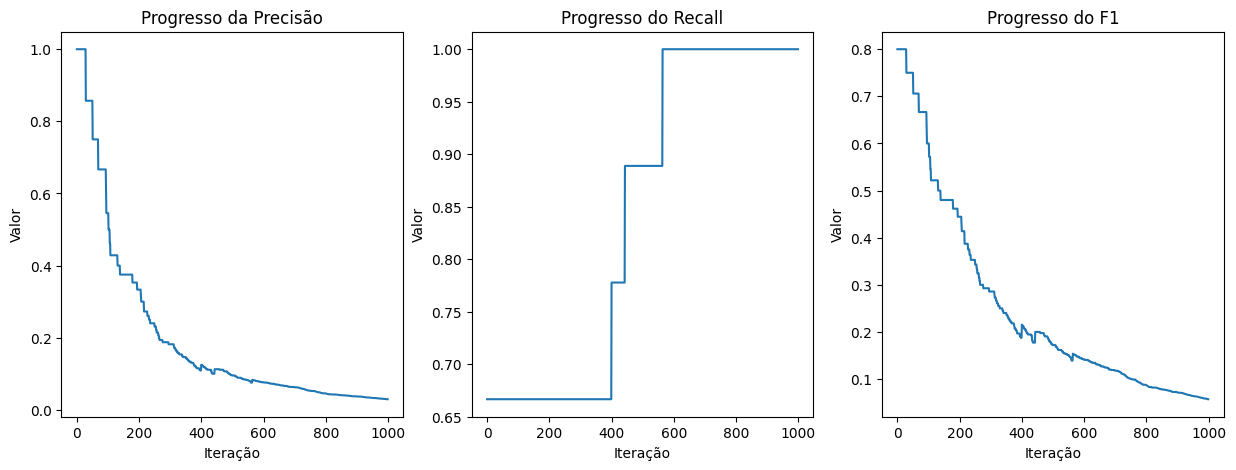

In [9]:
# Aumentar um pouco o tamanho do gráfico em relação ao padrão.
plt.figure(figsize=(15, 5))

# Plotar histórico de precisão.
plt.subplot(1, 3, 1)
plt.xlabel('Iteração')
plt.ylabel('Valor')
plt.title('Progresso da Precisão')
plt.plot(precision_history)

# Plotar histórico de recall.
plt.subplot(1, 3, 2)
plt.xlabel('Iteração')
plt.ylabel('Valor')
plt.title('Progresso do Recall')
plt.plot(recall_history)

# Plotar histórico de F1.
plt.subplot(1, 3, 3)
plt.xlabel('Iteração')
plt.ylabel('Valor')
plt.title('Progresso do F1')
plt.plot(f1_history)

# Mostrar todos os gráficos.
plt.show()

### Encontrar Outliers

Agora que calculamos o melhor `epsilon`, podemos encontrar os outliers.


[]

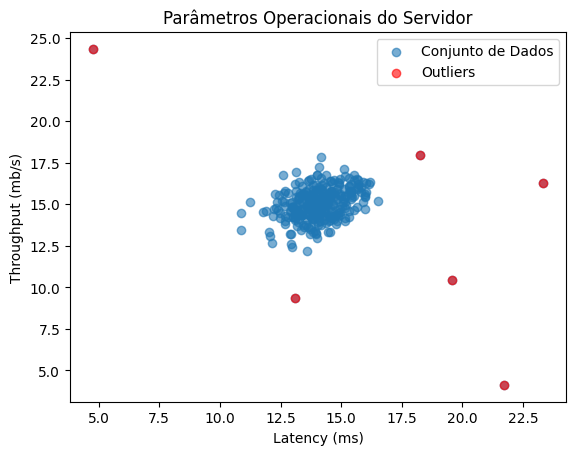

In [11]:
# Encontrar os índices dos exemplos de dados com probabilidades menores que o melhor epsilon.
outliers_indices = np.where(probabilities < epsilon)[0]

# Plotar os dados originais.
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, label='Conjunto de Dados')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Parâmetros Operacionais do Servidor')

# Plotar os outliers.
plt.scatter(data[outliers_indices, 0], data[outliers_indices, 1], alpha=0.6, c='red', label='Outliers')

# Mostrar legendas.
plt.legend()
plt.plot()
